Import wymaganych bibliotek

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from collections import defaultdict
sns.set(style="whitegrid")
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Import danych

In [62]:
movies = pd.read_csv('../data/movies.csv')
ratings = pd.read_csv('../data/ratings.csv')
tags = pd.read_csv('../data/tags.csv')

Podstawowa eksploracja danych

In [63]:
print("Ratings dataset:")
print(ratings.head())
print("\nMovies dataset:")
print(movies.head())

print(f"\nLiczba ocen: {len(ratings)}")
print(f"Liczba unikalnych użytkowników: {ratings.userId.nunique()}")
print(f"Liczba unikalnych filmów: {movies.movieId.nunique()}")
print(f"Zakres czasowy ocen: {pd.to_datetime(ratings.timestamp, unit='s').min()} - {pd.to_datetime(ratings.timestamp, unit='s').max()}")

Ratings dataset:
   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858

Movies dataset:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Liczba ocen: 32000204
Liczba unikalnych użytkowników: 200948
Liczba unikalnych filmów: 87585
Zakres czasowy ocen: 1995-01-09 11:46:44 - 2023-1

Rozkład ocen

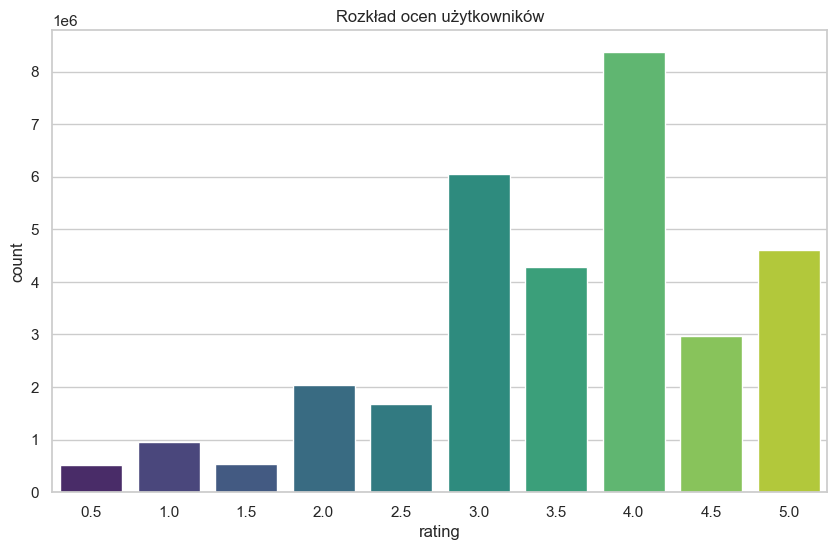

Średnia ocena: 3.54
Mediana ocen: 3.5


In [64]:
plt.figure(figsize=(10,6))
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Rozkład ocen użytkowników')
plt.show()

print(f"Średnia ocena: {ratings.rating.mean():.2f}")
print(f"Mediana ocen: {ratings.rating.median()}")

Analiza aktywności użytkowników

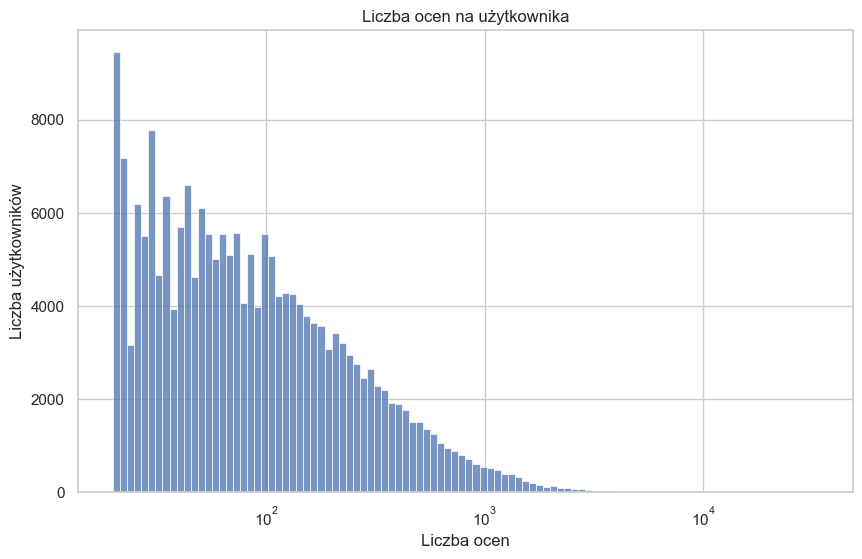

In [65]:
user_ratings = ratings['userId'].value_counts()
plt.figure(figsize=(10,6))
sns.histplot(user_ratings, bins=100, log_scale=(True, False))
plt.title('Liczba ocen na użytkownika')
plt.xlabel('Liczba ocen')
plt.ylabel('Liczba użytkowników')
plt.show()

Analiza popularności filmów

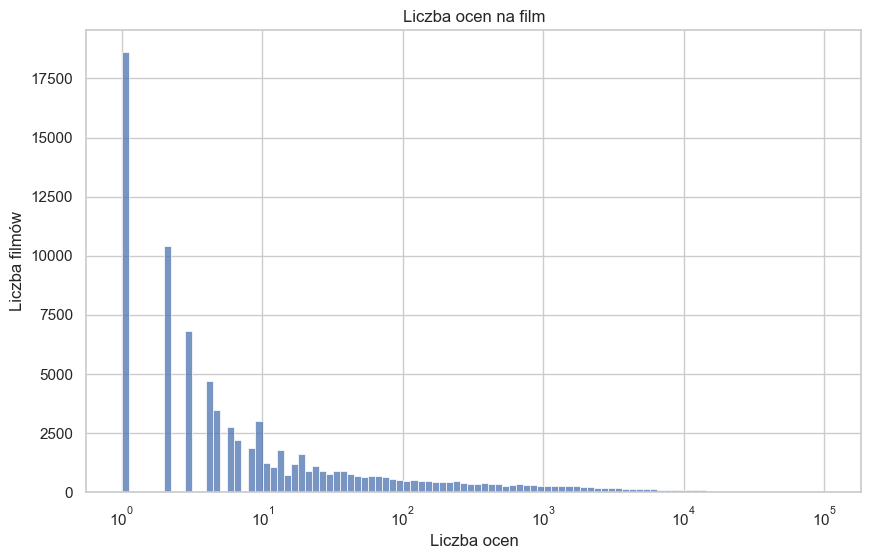


Top 10 najpopularniejszych filmów wg ilości ocen:
                                               title   count
0                   Shawshank Redemption, The (1994)  102929
1                                Forrest Gump (1994)  100296
2                                Pulp Fiction (1994)   98409
3                                 Matrix, The (1999)   93808
4                   Silence of the Lambs, The (1991)   90330
5          Star Wars: Episode IV - A New Hope (1977)   85010
6                                  Fight Club (1999)   77332
7                               Jurassic Park (1993)   75233
8                            Schindler's List (1993)   73849
9  Lord of the Rings: The Fellowship of the Ring,...   73122


In [66]:
movie_ratings = ratings['movieId'].value_counts().reset_index()
movie_ratings.columns = ['movieId', 'count']
movie_stats = movie_ratings.merge(movies, on='movieId')

plt.figure(figsize=(10,6))
sns.histplot(movie_ratings['count'], bins=100, log_scale=(True, False))
plt.title('Liczba ocen na film')
plt.xlabel('Liczba ocen')
plt.ylabel('Liczba filmów')
plt.show()

# Top 10 najpopularniejszych filmów wg ocen
top_movies = movie_stats.sort_values('count', ascending=False).head(10)
print("\nTop 10 najpopularniejszych filmów wg ilości ocen:")
print(top_movies[['title', 'count']])

Analiza gatunków filmów

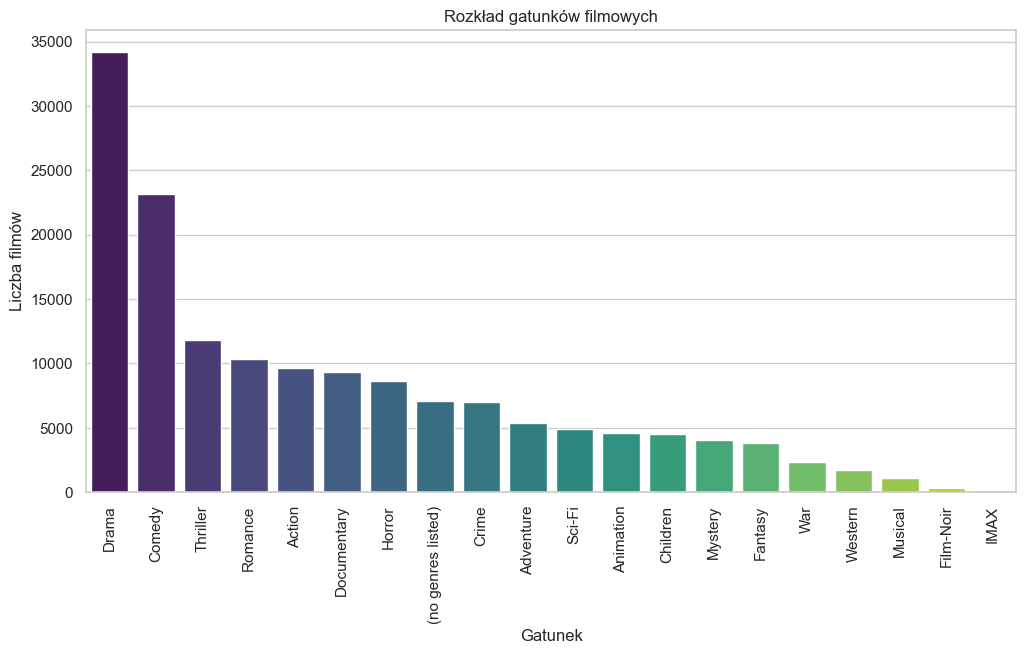

Średnia liczba gatunków na film: 1.76


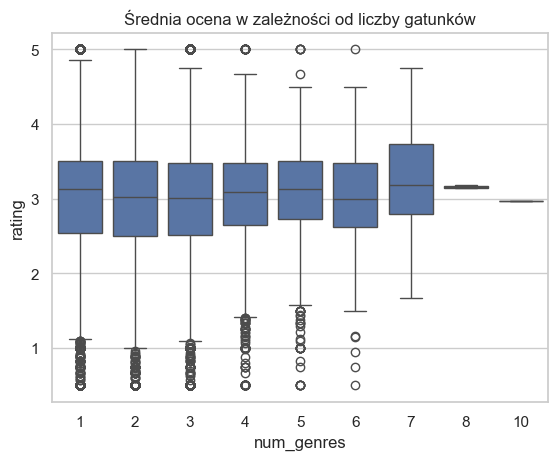

In [67]:
# Rozdzielenie gatunków na osobne kategorie
genres = defaultdict(int)
for movie in movies['genres']:
    for genre in movie.split('|'):
        genres[genre] += 1

genres_df = pd.DataFrame.from_dict(genres, orient='index', columns=['count']).sort_values('count', ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=genres_df.index, y=genres_df['count'], palette='viridis')
plt.xticks(rotation=90)
plt.title('Rozkład gatunków filmowych')
plt.xlabel('Gatunek')
plt.ylabel('Liczba filmów')
plt.show()

# Liczba gatunków na film
movies['num_genres'] = movies['genres'].apply(lambda x: len(x.split('|')))
print(f"Średnia liczba gatunków na film: {movies['num_genres'].mean():.2f}")

# Relacja między liczbą gatunków a popularnością/ocenami
genre_count_analysis = movies.merge(ratings.groupby('movieId')['rating'].mean().reset_index(), on='movieId')
sns.boxplot(x='num_genres', y='rating', data=genre_count_analysis)
plt.title('Średnia ocena w zależności od liczby gatunków')
plt.show()

Macierz rzadkości

In [68]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
sparsity = (1 - len(ratings)/(n_users * n_movies)) * 100
print(f"\nSparsity(Rzadkość): {sparsity:.2f}%")


Sparsity(Rzadkość): 99.81%


Analiza jakościowa filmów

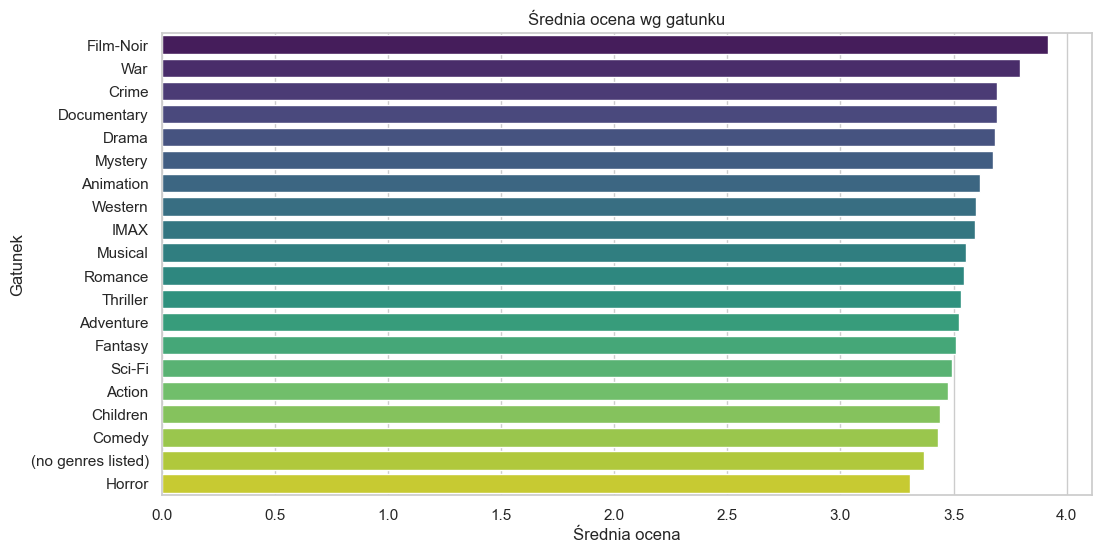

In [72]:
# Łączymy dane o ocenach z metadanymi filmów
merged = ratings.merge(movies, on='movieId')

# Średnia ocena dla poszczególnych gatunków
genres_ratings = []
for genre in genres_df.index:
    mask = merged['genres'].str.contains(genre)
    avg_rating = merged.loc[mask, 'rating'].mean()
    genres_ratings.append((genre, avg_rating))

genres_ratings_df = pd.DataFrame(genres_ratings, columns=['Genre', 'Avg Rating']).sort_values('Avg Rating', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='Avg Rating', y='Genre', data=genres_ratings_df, palette='viridis')
plt.title('Średnia ocena wg gatunku')
plt.xlabel('Średnia ocena')
plt.ylabel('Gatunek')
plt.show()

Analiza tagów poszczególnych filmów

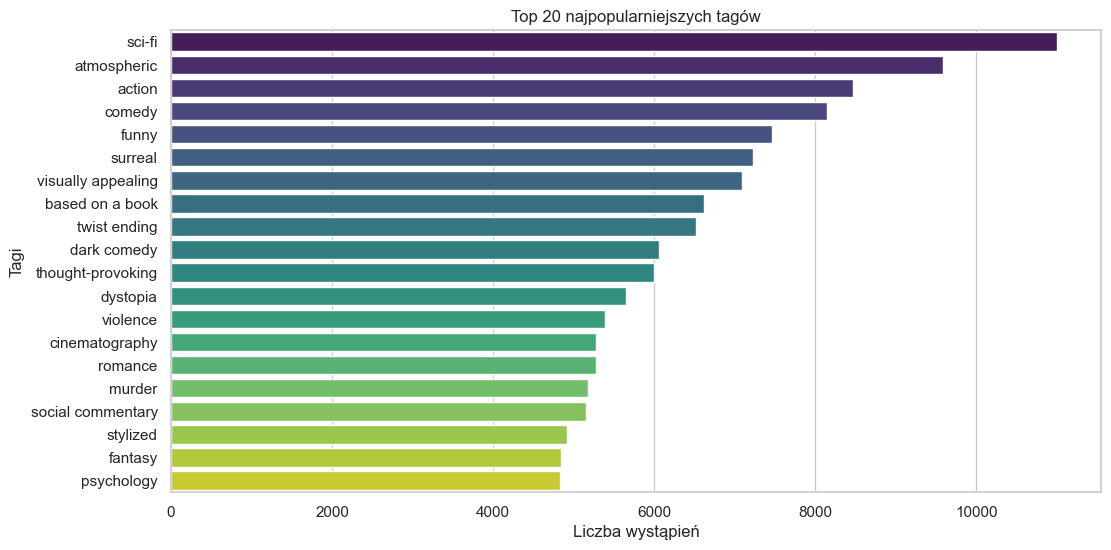

                        mean  count
tag                                
sci-fi              3.961934  10508
atmospheric         4.213926   9321
action              3.866782   8077
comedy              3.928873   7571
funny               4.056887   7260
surreal             4.209636   6974
visually appealing  4.159882   6927
twist ending        4.242007   6349
thought-provoking   4.377865   5846
dark comedy         4.190826   5657


In [73]:
# Popularność tagów
tag_counts = tags['tag'].value_counts().head(20)
plt.figure(figsize=(12,6))
sns.barplot(y=tag_counts.index, x=tag_counts.values, palette="viridis")
plt.title('Top 20 najpopularniejszych tagów')
plt.xlabel('Liczba wystąpień')
plt.ylabel('Tagi')
plt.show()

# Relacja między tagami a ocenami (przykład dla wybranego tagu)
merged_tags = ratings.merge(tags, on=['userId', 'movieId'])
tag_analysis = merged_tags.groupby('tag')['rating'].agg(['mean', 'count'])
print(tag_analysis.sort_values('count', ascending=False).head(10))

Eksploracja tekstów tytułów filmów

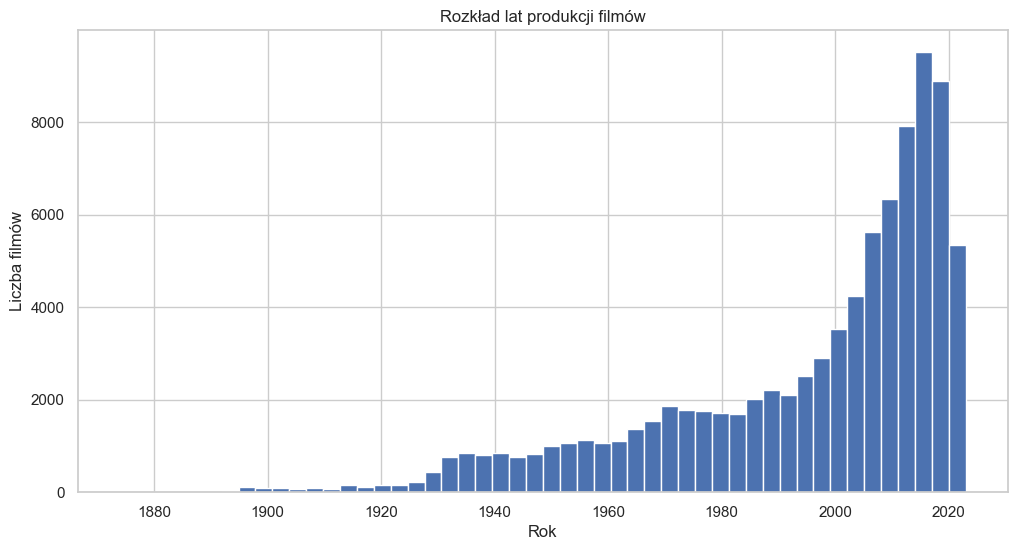

Liczba wszystkich słów w tytułach filmów: 282955
Liczba wszystkich unikalnych słów w tytułach filmów: 56378


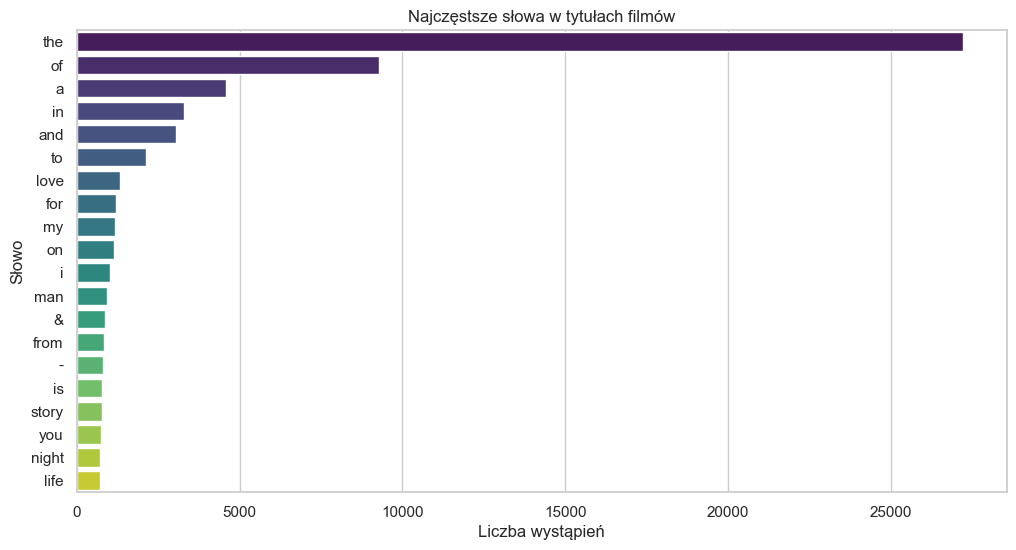

Liczba wszystkich słów w tytułach filmów po oczyszczeniu: 195781
Liczba wszystkich unikalnych słów w tytułach filmów po oczyszczeniu: 39515


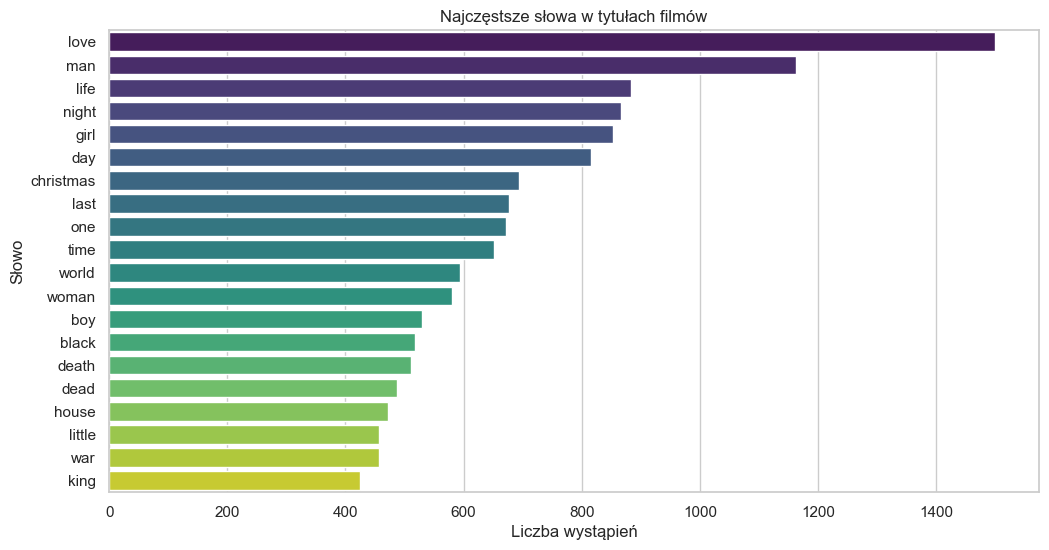

In [75]:
# Ekstrakcja roku z tytułów
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)

# Rozkład lat produkcji filmów
plt.figure(figsize=(12,6))
movies['year'].hist(bins=50)
plt.title('Rozkład lat produkcji filmów')
plt.xlabel('Rok')
plt.ylabel('Liczba filmów')
plt.show()

# Najpopularniejsze słowa w tytułach filmów bez oczyszczania
title_words = ' '.join(movies['title'].str.replace(r'\(\d{4}\)', '', regex=True))
print(f"Liczba wszystkich słów w tytułach filmów: {len(title_words.split())}")
title_words = title_words.lower()
title_words = title_words.split()
title_word_counts = defaultdict(int)
for word in title_words:
    title_word_counts[word] += 1
print(f"Liczba wszystkich unikalnych słów w tytułach filmów: {len(title_word_counts.keys())}")

plt.figure(figsize=(12,6))
word_counts_df = pd.DataFrame.from_dict(title_word_counts, orient='index', columns=['count']).sort_values('count', ascending=False).head(20)
sns.barplot(x=word_counts_df['count'], y=word_counts_df.index, palette='viridis')
plt.title('Najczęstsze słowa w tytułach filmów')
plt.xlabel('Liczba wystąpień')
plt.ylabel('Słowo')
plt.show()

# Najpopularniejsze słowa w tytułach filmów po oczyszceniu
wc_module_path = os.path.abspath(os.path.join('..', 'src'))
if wc_module_path not in sys.path:
    sys.path.append(wc_module_path)
from wordcleaner import TitleCleaner
cleaner = TitleCleaner()

movies['cleaned_title'] = movies['title'].apply(lambda x: cleaner.clean_title(x))
cleaned_title_words = ' '.join(movies['cleaned_title'])
print(f"Liczba wszystkich słów w tytułach filmów po oczyszczeniu: {len(cleaned_title_words.split())}")
cleaned_title_word_counts = defaultdict(int)
for word in cleaned_title_words.split():
    cleaned_title_word_counts[word] += 1
print(f"Liczba wszystkich unikalnych słów w tytułach filmów po oczyszczeniu: {len(cleaned_title_word_counts.keys())}")

plt.figure(figsize=(12,6))
cleaned_word_counts_df = pd.DataFrame.from_dict(cleaned_title_word_counts, orient='index', columns=['count']).sort_values('count', ascending=False).head(20)
sns.barplot(x=cleaned_word_counts_df['count'], y=cleaned_word_counts_df.index, palette='viridis')
plt.title('Najczęstsze słowa w tytułach filmów')
plt.xlabel('Liczba wystąpień')
plt.ylabel('Słowo')
plt.show()

# Zapisanie oczyszczonych tytułów do pliku CSV
movies[['movieId', 'cleaned_title']].to_csv('clean_titles.csv', index=False)

Jakość danych dla metody content-based

In [76]:
# Brakujące dane w metadanych
print("Brakujące wartości w movies.csv:")
print(movies.isnull().sum())

# Spójność danych

# Gatunki
print(f"Liczba filmów bez gatunków: {movies[movies['genres'] == '(no genres listed)'].shape[0]}")

# Tagi
movies_with_tags = tags['movieId'].unique()
movies['has_tags'] = movies['movieId'].isin(movies_with_tags)
no_tag_count = len(movies) - movies['has_tags'].sum()
print(f"Filmy bez żadnych tagów: {no_tag_count} ({(no_tag_count/len(movies))*100:.2f}%)")


Brakujące wartości w movies.csv:
movieId            0
title              0
genres             0
num_genres         0
year             615
cleaned_title      0
dtype: int64
Liczba filmów bez gatunków: 7080
Filmy bez żadnych tagów: 36262 (41.40%)
